In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from numpy import pi 
import time
from MaxCutSolver import MaxCutSolver

In [3]:
def get_cost_graph(bitstring, graph):
    cost = 0
    for i, j in graph.edges():
        if bitstring[i] != bitstring[j]:
            cost += 1
    return cost

def get_objective(number_nodes, obj_cost):
    G = nx.generators.classic.complete_graph(number_nodes)
    #G = nx.generators.erdos_renyi_graph(number_nodes, 0.8)
    nx.draw(G, with_labels=True, alpha=0.8, node_size=500)
    best_candidate = ""
    best_cost = 0
    solutions = list()
    for i in range(0,2**number_nodes):
        candidate = "0"*(number_nodes-len(bin(i).replace("0b", "")))+bin(i).replace("0b", "")
        candidate_cost = get_cost_graph(candidate, G)
        if(candidate_cost > best_cost):
            best_candidate = candidate
            best_cost = candidate_cost
        if(candidate_cost == obj_cost):
            solutions.append(best_candidate)
    print(best_candidate, best_cost)
    return G, solutions

In [4]:
def test_n_nodes(number_nodes,objective, G, solutions):
    #G = nx.generators.classic.complete_graph(number_nodes)
    gradient_values_nm_p = list()
    gradient_values_cobyla_p = list()
    gradient_values_slsqp_p = list()
    swarm_values_p = list()
    bats_values_p = list()
    ants_values_p = list()
    bees_values_p = list()
    gradient_values_nm = list()
    gradient_values_cobyla = list()
    gradient_values_slsqp = list()
    swarm_values = list()
    bats_values = list()
    ants_values = list()
    bees_values = list()
    gradient_time_nm = list()
    gradient_time_cobyla = list()
    gradient_time_slsqp = list()
    swarm_time = list()
    bats_time = list()
    ants_time = list()
    bees_time = list()
    gradient_solutions_nm = list()
    gradient_solutions_cobyla = list()
    gradient_solutions_slsqp = list()
    swarm_solutions = list()
    bats_solutions = list()
    ants_solutions = list()
    bees_solutions = list()
    p_range = 8
    for i in range(1, p_range):
        myanzats = MaxCutSolver(graph=G, num_qubits=number_nodes, backend='qasm_simulator', p=i)
        start_time = time.time()
        opt_gradient_nm = myanzats.optimize_classic(method='Nelder-Mead')
        gradient_time_nm.append(time.time() - start_time)
        start_time = time.time()
        opt_gradient_cobyla = myanzats.optimize_classic(method='COBYLA').x
        gradient_time_cobyla.append(time.time() - start_time)
        start_time = time.time()
        opt_gradient_slsqp = myanzats.optimize_classic(method='SLSQP')
        gradient_time_slsqp.append(time.time() - start_time)
        start_time = time.time()
        opt_bats = myanzats.optimize_bats([0,pi])
        bats_time.append(time.time() - start_time )
        start_time = time.time()
        opt_ants,iter_ants = myanzats.optimize_ants([-5,5])
        ants_time.append(time.time() - start_time)
        start_time = time.time()
        opt_swarm = myanzats.optimize_swarm([-5,5])
        swarm_time.append(time.time() - start_time)
        start_time = time.time()
        opt_bee = myanzats.optimize_bees([0,2*pi])
        bees_time.append(time.time() - start_time)

        opt_gradient_nm = myanzats.optimize_classic(method='Nelder-Mead').x
        opt_gradient_slsqp = myanzats.optimize_classic(method='SLSQP').x

        mean_gradient_p_nm = 0
        mean_gradient_p_cobyla = 0
        mean_gradient_p_slsqp = 0
        mean_ants_p = 0
        mean_bats_p = 0
        mean_swarm_p = 0
        mean_bees_p = 0
        mean_gradient_nm = 0
        mean_gradient_cobyla = 0
        mean_gradient_slsqp = 0
        mean_ants = 0
        mean_bats = 0
        mean_swarm = 0
        mean_bees = 0
        
        mean_gradient_sol_nm = 0
        mean_gradient_sol_cobyla = 0
        mean_gradient_sol_slsqp = 0
        mean_ants_sol = 0
        mean_bats_sol = 0
        mean_swarm_sol = 0
        mean_bees_sol = 0

        for i in range(0,30):

            gradient_dict_nm = myanzats.output_circuit(opt_gradient_nm)
            gradient_dict_cobyla = myanzats.output_circuit(opt_gradient_cobyla)
            gradient_dict_slsqp = myanzats.output_circuit(opt_gradient_slsqp)
            swarm_dict = myanzats.output_circuit(opt_swarm)
            bats_dict = myanzats.output_circuit(opt_bats)
            ants_dict = myanzats.output_circuit(opt_ants)
            bees_dict = myanzats.output_circuit(opt_bee)

            mean_bats_p = 0 if not objective in bats_dict else bats_dict[objective]/max(bats_dict.values())
            mean_swarm_p = 0 if not objective in swarm_dict else swarm_dict[objective]/max(swarm_dict.values())
            mean_gradient_p_nm = 0 if not objective in gradient_dict_nm else gradient_dict_nm[objective]/max(gradient_dict_nm.values())
            mean_gradient_p_cobyla = 0 if not objective in gradient_dict_cobyla else gradient_dict_cobyla[objective]/max(gradient_dict_cobyla.values())
            mean_gradient_p_slsqp = 0 if not objective in gradient_dict_slsqp else gradient_dict_slsqp[objective]/max(gradient_dict_slsqp.values())
            mean_ants_p = 0 if not objective in ants_dict else ants_dict[objective]/max(ants_dict.values())
            mean_bees_p = 0 if not objective in bees_dict else bees_dict[objective]/max(bees_dict.values())
            

            mean_gradient_nm += 0 if not objective in gradient_dict_nm else gradient_dict_nm[objective]/1000  
            mean_gradient_cobyla += 0 if not objective in gradient_dict_cobyla else gradient_dict_cobyla[objective]/1000
            mean_gradient_slsqp += 0 if not objective in gradient_dict_slsqp else gradient_dict_slsqp[objective]/1000
            mean_swarm += 0 if not objective in swarm_dict else swarm_dict[objective]/1000 
            mean_bats += 0 if not objective in bats_dict else bats_dict[objective]/1000 
            mean_ants += 0 if not objective in ants_dict else ants_dict[objective]/1000
            mean_bees += 0 if not objective in bees_dict else bees_dict[objective]/1000

            for sol in solutions:
                mean_gradient_sol_nm += 0 if not sol in gradient_dict_nm else gradient_dict_nm[sol]/1000  
                mean_gradient_sol_cobyla += 0 if not sol in gradient_dict_cobyla else gradient_dict_cobyla[sol]/1000
                mean_gradient_sol_slsqp += 0 if not sol in gradient_dict_slsqp else gradient_dict_slsqp[sol]/1000
                mean_swarm_sol += 0 if not sol in swarm_dict else swarm_dict[sol]/1000 
                mean_bats_sol += 0 if not sol in bats_dict else bats_dict[sol]/1000 
                mean_ants_sol += 0 if not sol in ants_dict else ants_dict[sol]/1000
                mean_bees_sol += 0 if not sol in bees_dict else bees_dict[sol]/1000


        bats_values.append(mean_bats/30)
        swarm_values.append(mean_swarm/30)
        gradient_values_nm.append(mean_gradient_nm/30)
        gradient_values_cobyla.append(mean_gradient_cobyla/30)
        gradient_values_slsqp.append(mean_gradient_slsqp/30)
        ants_values.append(mean_ants/30)
        bees_values.append(mean_bees/30)
        bats_values_p.append(mean_bats_p/30)
        swarm_values_p.append(mean_swarm_p/30)
        gradient_values_nm_p.append(mean_gradient_p_nm/30)
        gradient_values_cobyla_p.append(mean_gradient_p_cobyla/30)
        gradient_values_slsqp_p.append(mean_gradient_p_slsqp/30)
        ants_values_p.append(mean_ants_p/30)
        bees_values_p.append(mean_bees_p/30)


        bats_solutions.append(mean_bats_sol/30)
        swarm_solutions.append(mean_swarm_sol/30)
        gradient_solutions_nm.append(mean_gradient_sol_nm/30)
        gradient_solutions_cobyla.append(mean_gradient_sol_cobyla/30)
        gradient_solutions_slsqp.append(mean_gradient_sol_slsqp/30)
        ants_solutions.append(mean_ants_sol/30)
        bees_solutions.append(mean_bees_sol/30)
    
    print("\n")


    print("gradient_sum_nm="+str(gradient_solutions_nm))
    print("gradient_sum_cobyla="+str(gradient_solutions_cobyla))
    print("gradient_sum_slsqp="+str(gradient_solutions_slsqp))
    print("swarm_sum"+str(swarm_solutions))
    print("bats_sum="+str(bats_solutions))
    print("ants_sum="+str(ants_solutions))
    print("bees_sum="+str(bees_solutions))


    plt.plot(list(range(1,p_range)), gradient_solutions_nm, '-o')
    plt.plot(list(range(1,p_range)), gradient_solutions_cobyla, '-o')
    plt.plot(list(range(1,p_range)), gradient_solutions_slsqp, '-o')
    plt.plot(list(range(1,p_range)), swarm_solutions, '-o')
    plt.plot(list(range(1,p_range)), bats_solutions, '-o')
    plt.plot(list(range(1,p_range)), ants_solutions, '-o')
    plt.plot(list(range(1,p_range)), bees_solutions, '-o')
    plt.legend(["Nelder-Mead", "COBYLA", "SLSQP", "PSO", "BA", "ACO", "ABC"])
    plt.title("P value vs probability of getting a correct solution for 1000 shots on QASM simulator")
    plt.xlabel('p-value', fontsize=18)
    plt.ylabel('probability', fontsize=16)
    plt.show()


    print("gradient_values_nm_p="+str(gradient_values_nm_p))
    print("gradient_values_cobyla_p="+str(gradient_values_cobyla_p))
    print("gradient_values_slsqp_p="+str(gradient_values_slsqp_p))
    print("swarm_values_p"+str(swarm_values_p))
    print("bats_values_p="+str(bats_values_p))
    print("ants_values_p="+str(ants_values_p))
    print("bees_values_p="+str(bees_values_p))


    plt.plot(list(range(1,p_range)), gradient_values_nm_p, '-o')
    plt.plot(list(range(1,p_range)), gradient_values_cobyla_p, '-o')
    plt.plot(list(range(1,p_range)), gradient_values_slsqp_p, '-o')
    plt.plot(list(range(1,p_range)), swarm_values_p, '-o')
    plt.plot(list(range(1,p_range)), bats_values_p, '-o')
    plt.plot(list(range(1,p_range)), ants_values_p, '-o')
    plt.plot(list(range(1,p_range)), bees_values_p, '-o')
    plt.legend(["Nelder-Mead", "COBYLA","SLSQP","PSO", "BA", "ACO", "ABC"])
    plt.title("P value vs approximation ratio for 1000 shots on QASM simulator")
    plt.xlabel('p-value', fontsize=18)
    plt.ylabel('approximation ratio', fontsize=16)
    plt.show()

    print("gradient_values_nm="+str(gradient_values_nm))
    print("gradient_values_cobyla="+str(gradient_values_cobyla))
    print("gradient_values_slsqp="+str(gradient_values_slsqp))
    print("swarm_values="+str(swarm_values))
    print("bats_values="+str(bats_values))
    print("ants_values="+str(ants_values))
    print("bees_values="+str(bees_values))

    plt.plot(list(range(1,p_range)), gradient_values_nm, '-o')
    plt.plot(list(range(1,p_range)), gradient_values_cobyla, '-o')
    plt.plot(list(range(1,p_range)), gradient_values_slsqp, '-o')
    plt.plot(list(range(1,p_range)), swarm_values, '-o')
    plt.plot(list(range(1,p_range)), bats_values, '-o')
    plt.plot(list(range(1,p_range)), ants_values, '-o')
    plt.plot(list(range(1,p_range)), bees_values, '-o')
    plt.legend(["Nelder-Mead", "COBYLA","SLSQP","PSO", "BA", "ACO", "ABC"])
    plt.title("P value vs ground state probability for 1000 shots on QASM simulator")
    plt.xlabel('p-value', fontsize=18)
    plt.ylabel('probability', fontsize=16)
    plt.show()

    print( "gradient_time_nm=" +str(gradient_time_nm))
    print( "gradient_time_cobyla=" +str(gradient_time_cobyla))
    print( "gradient_time_slsqp=" +str(gradient_time_slsqp))
    print( "swarm_time=" +str(swarm_time))
    print( "bats_time=" +str(bats_time))
    print( "ants_time=" +str(ants_time))
    print( "bees_time=" +str(bees_time))

    plt.plot(list(range(1,p_range)), gradient_time_nm, '-o')
    plt.plot(list(range(1,p_range)), gradient_time_cobyla, '-o')
    plt.plot(list(range(1,p_range)), gradient_time_slsqp, '-o')
    plt.plot(list(range(1,p_range)), swarm_time, '-o')
    plt.plot(list(range(1,p_range)), bats_time, '-o')
    plt.plot(list(range(1,p_range)), ants_time, '-o')
    plt.plot(list(range(1,p_range)), bees_time, '-o')
    plt.legend(["Nelder-Mead", "COBYLA","SLSQP","PSO", "BA", "ACO", "ABC"])
    plt.title("P value vs execution time for 1000 shots on QASM simulator")
    plt.xlabel('p-value', fontsize=18)
    plt.ylabel('execution time', fontsize=16)
    plt.show()

# 4 nodes graph

0011 4


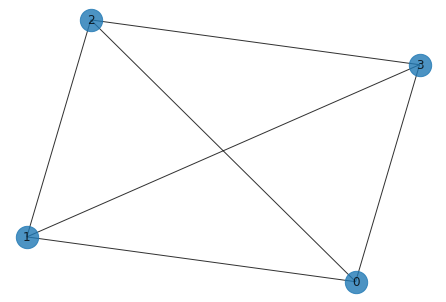

In [10]:
G, solutions = get_objective(4, 4)



gradient_sum_nm=[0.18159999999999987, 0.09579999999999986, 0.9093999999999998, 0.5312000000000004, 0.9995999999999989, 0.9537999999999996, 1.001200000000001]
gradient_sum_cobyla=[0.7433999999999998, 0.45120000000000043, 0.9744000000000008, 0.7480000000000006, 0.7545999999999999, 1.0031999999999983, 1.0040000000000002]
gradient_sum_slsqp=[0.24580000000000002, 0.5966, 0.43260000000000054, 0.677200000000001, 0.05719999999999987, 0.5166000000000002, 0.928]
swarm_sum[0.815400000000001, 0.9875999999999987, 0.9326, 0.9092000000000005, 0.9757999999999992, 1.0050000000000001, 0.9498000000000008]
bats_sum=[0.7775999999999997, 0.9736000000000001, 0.952, 0.9879999999999985, 0.877200000000001, 0.9517999999999993, 0.9965999999999973]
ants_sum=[0.8016000000000001, 0.8325999999999997, 0.9319999999999994, 0.8197999999999998, 0.7374000000000015, 0.8698000000000008, 0.9512]
bees_sum=[0.8048000000000003, 0.9894000000000004, 0.9823999999999987, 0.9841999999999989, 0.9072, 0.9569999999999993, 0.9922000000

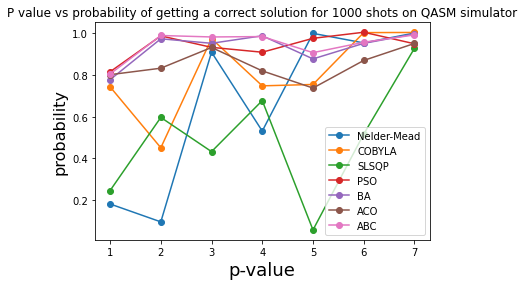

gradient_values_nm_p=[0.003896103896103896, 0.005970149253731343, 0.028542914171656684, 0.029372937293729372, 0.03333333333333333, 0.03186813186813187, 0.03333333333333333]
gradient_values_cobyla_p=[0.030043859649122807, 0.032196969696969696, 0.0329608938547486, 0.026576576576576576, 0.029195402298850575, 0.02912087912087912, 0.026701570680628273]
gradient_values_slsqp_p=[0.009050772626931568, 0.02897196261682243, 0.02682926829268293, 0.026822916666666665, 0.0032634032634032634, 0.019620253164556962, 0.02774774774774775]
swarm_values_p[0.03127853881278539, 0.026094276094276097, 0.03313131313131313, 0.03128834355828221, 0.03277153558052434, 0.03333333333333333, 0.02872340425531915]
bats_values_p=[0.0289760348583878, 0.032947976878612714, 0.03333333333333333, 0.03186003683241252, 0.0310126582278481, 0.02596899224806202, 0.03333333333333333]
ants_values_p=[0.02947845804988662, 0.02774193548387097, 0.02975517890772128, 0.03200883002207506, 0.027044025157232705, 0.026120857699805065, 0.0289

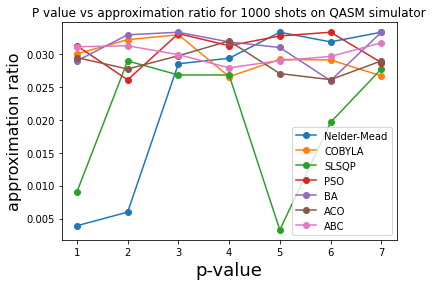

gradient_values_nm=[0.030266666666666685, 0.015966666666666674, 0.15156666666666666, 0.08853333333333334, 0.1666, 0.15896666666666665, 0.16686666666666666]
gradient_values_cobyla=[0.12390000000000002, 0.07519999999999999, 0.16239999999999996, 0.12466666666666666, 0.12576666666666667, 0.16719999999999993, 0.1673333333333333]
gradient_values_slsqp=[0.04096666666666668, 0.09943333333333333, 0.0721, 0.11286666666666668, 0.009533333333333338, 0.08610000000000002, 0.15466666666666665]
swarm_values=[0.1359, 0.16460000000000002, 0.1554333333333333, 0.15153333333333333, 0.1626333333333333, 0.1675, 0.15829999999999994]
bats_values=[0.12960000000000002, 0.1622666666666667, 0.15866666666666665, 0.16466666666666668, 0.14619999999999997, 0.15863333333333335, 0.1661]
ants_values=[0.13360000000000002, 0.13876666666666668, 0.15533333333333338, 0.1366333333333333, 0.12290000000000002, 0.14496666666666666, 0.1585333333333333]
bees_values=[0.13413333333333333, 0.1649, 0.16373333333333334, 0.16403333333333

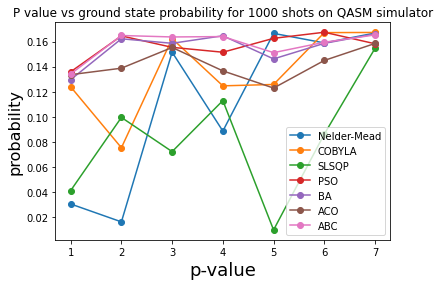

gradient_time_nm=[12.084779739379883, 28.885550022125244, 62.37009263038635, 91.52993369102478, 133.58935570716858, 184.10668230056763, 245.59537935256958]
gradient_time_cobyla=[0.7255105972290039, 1.2745678424835205, 4.604688405990601, 5.278690576553345, 6.690704584121704, 10.278924942016602, 12.09134554862976]
gradient_time_slsqp=[3.618847370147705, 9.202504873275757, 25.21911597251892, 47.82049012184143, 77.46788144111633, 120.54343962669373, 144.5440332889557]
swarm_time=[27.939095497131348, 37.39686679840088, 46.32114338874817, 58.024702072143555, 61.168163537979126, 79.43165564537048, 84.30931663513184]
bats_time=[75.98774266242981, 107.33548641204834, 132.58670902252197, 164.85756468772888, 171.73471212387085, 226.94043278694153, 235.14562034606934]
ants_time=[35.47791910171509, 46.781516551971436, 59.625099182128906, 76.65397047996521, 79.8218514919281, 104.36173725128174, 105.44413352012634]
bees_time=[62.32055878639221, 88.68863654136658, 100.48487305641174, 134.2334766387939

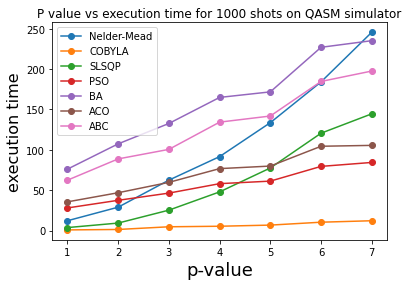

In [11]:
test_n_nodes(4,'0011', G, solutions) 

# 5 nodes graph

00011 6


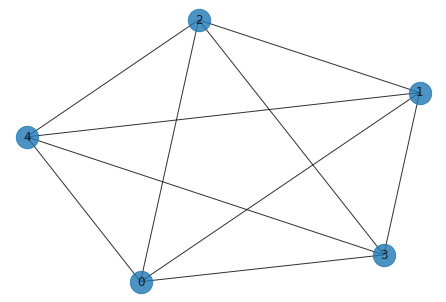

In [12]:
G, solutions = get_objective(5, 6)



gradient_sum_nm=[0.2779999999999982, 0.5239999999999975, 0.5253333333333319, 1.0246666666666586, 0.8226666666666663, 0.9719999999999982, 1.011333333333335]
gradient_sum_cobyla=[1.039333333333331, 1.0053333333333347, 1.001333333333333, 1.0273333333333337, 1.0093333333333339, 1.0293333333333305, 0.995333333333332]
gradient_sum_slsqp=[0.4566666666666675, 0.38266666666666743, 0.5166666666666665, 0.6839999999999992, 0.5019999999999967, 0.08999999999999936, 0.741333333333334]
swarm_sum[0.9800000000000041, 0.9640000000000019, 0.9839999999999952, 0.9873333333333331, 0.9753333333333349, 0.9946666666666623, 0.9593333333333338]
bats_sum=[0.9779999999999975, 0.9779999999999991, 0.9799999999999992, 0.9953333333333345, 0.9406666666666607, 0.9826666666666665, 0.9746666666666645]
ants_sum=[0.8980000000000025, 0.9726666666666709, 0.9186666666666702, 0.921333333333332, 0.8973333333333345, 0.8186666666666648, 0.9999999999999957]
bees_sum=[0.9913333333333337, 0.9653333333333328, 0.962666666666662, 0.985

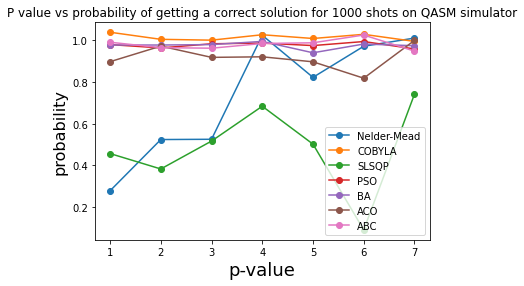

gradient_values_nm_p=[0.0017241379310344827, 0.01149425287356322, 0.004273504273504273, 0.027692307692307693, 0.024836601307189544, 0.024242424242424242, 0.024479166666666666]
gradient_values_cobyla_p=[0.03333333333333333, 0.028415300546448086, 0.029444444444444443, 0.029100529100529102, 0.029943502824858758, 0.028645833333333332, 0.0273224043715847]
gradient_values_slsqp_p=[0.011794871794871795, 0.001928374655647383, 0.010691823899371069, 0.01623931623931624, 0.009737827715355805, 0.001020408163265306, 0.03333333333333333]
swarm_values_p[0.02, 0.02238805970149254, 0.026436781609195402, 0.025, 0.03333333333333333, 0.027230046948356807, 0.030459770114942532]
bats_values_p=[0.02666666666666667, 0.020588235294117647, 0.025252525252525252, 0.027083333333333334, 0.03333333333333333, 0.026027397260273973, 0.02777777777777778]
ants_values_p=[0.025925925925925925, 0.02413793103448276, 0.0273224043715847, 0.027210884353741496, 0.03133333333333333, 0.02303030303030303, 0.02328042328042328]
bees_

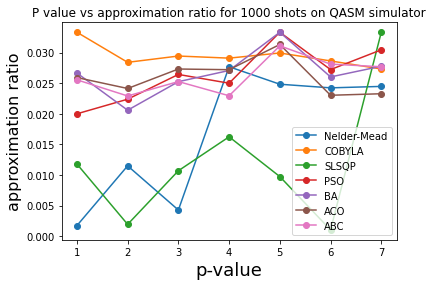

gradient_values_nm=[0.013900000000000004, 0.026200000000000015, 0.026266666666666678, 0.05123333333333334, 0.04113333333333335, 0.048600000000000004, 0.050566666666666676]
gradient_values_cobyla=[0.05196666666666667, 0.050266666666666675, 0.05006666666666669, 0.05136666666666667, 0.05046666666666668, 0.05146666666666667, 0.049766666666666674]
gradient_values_slsqp=[0.02283333333333334, 0.01913333333333334, 0.025833333333333344, 0.034200000000000015, 0.025100000000000015, 0.004500000000000001, 0.03706666666666668]
swarm_values=[0.04900000000000001, 0.048200000000000014, 0.04920000000000001, 0.04936666666666667, 0.04876666666666666, 0.049733333333333345, 0.04796666666666667]
bats_values=[0.048900000000000006, 0.04890000000000002, 0.049, 0.049766666666666674, 0.047033333333333344, 0.04913333333333334, 0.04873333333333334]
ants_values=[0.044900000000000016, 0.048633333333333334, 0.04593333333333335, 0.04606666666666668, 0.04486666666666668, 0.04093333333333335, 0.05000000000000001]
bees_va

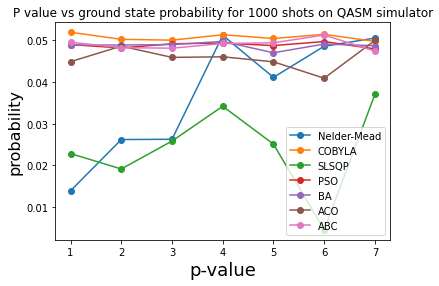

gradient_time_nm=[13.581761837005615, 37.396764039993286, 71.09983730316162, 115.3311972618103, 169.3952009677887, 205.17478275299072, 270.19370770454407]
gradient_time_cobyla=[0.9614279270172119, 2.4460678100585938, 4.2110466957092285, 5.427799463272095, 7.901111841201782, 10.238473653793335, 13.218707799911499]
gradient_time_slsqp=[4.86600399017334, 11.87911581993103, 32.210020303726196, 56.68154168128967, 96.34229826927185, 125.91508865356445, 99.05490636825562]
swarm_time=[35.642584800720215, 47.68496775627136, 60.41885733604431, 73.22991013526917, 75.83984327316284, 87.11019253730774, 98.12134003639221]
bats_time=[102.63676357269287, 134.1775336265564, 171.3750433921814, 206.3540997505188, 245.0823998451233, 246.62545943260193, 279.4075119495392]
ants_time=[46.117358446121216, 61.994078397750854, 79.07541632652283, 96.47169256210327, 99.70667386054993, 113.56012916564941, 128.79357314109802]
bees_time=[79.6749792098999, 110.35801720619202, 139.89516019821167, 170.0690267086029, 17

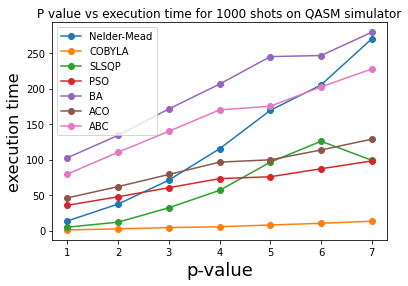

In [13]:
test_n_nodes(5,'00011', G, solutions)

# 6 nodes graph

000111 9


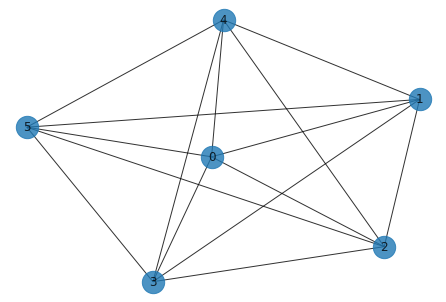

In [14]:
G, solutions = get_objective(6, 9)



gradient_sum_nm=[0.5893333333333306, 0.16266666666666607, 0.22599999999999928, 0.9079999999999996, 0.44199999999999906, 0.956666666666668, 0.8306666666666662]
gradient_sum_cobyla=[0.6559999999999986, 0.833999999999998, 0.970000000000003, 0.7386666666666655, 0.8133333333333336, 0.8286666666666638, 1.011333333333328]
gradient_sum_slsqp=[0.010000000000000007, 0.5113333333333324, 0.4046666666666661, 0.08666666666666598, 0.329333333333332, 0.37399999999999894, 0.05199999999999952]
swarm_sum[0.6873333333333349, 0.8799999999999985, 0.5360000000000001, 0.9206666666666699, 0.7293333333333363, 0.9413333333333326, 0.879333333333333]
bats_sum=[0.6506666666666683, 0.7259999999999991, 0.5726666666666682, 0.7759999999999997, 0.9979999999999942, 0.9733333333333292, 0.6580000000000035]
ants_sum=[0.6593333333333311, 0.9280000000000023, 0.9333333333333318, 0.9993333333333279, 0.8866666666666646, 0.8879999999999987, 0.8660000000000022]
bees_sum=[0.6600000000000003, 0.7026666666666656, 0.7146666666666681

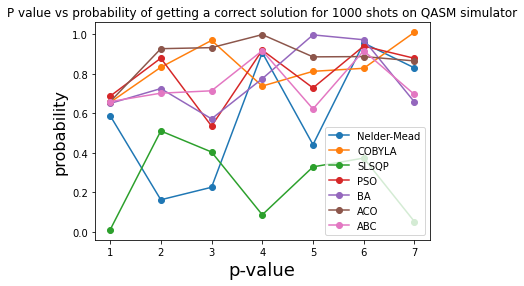

gradient_values_nm_p=[0.016666666666666666, 0.0005405405405405405, 0.01264367816091954, 0.024404761904761905, 0.030000000000000002, 0.02413793103448276, 0.02222222222222222]
gradient_values_cobyla_p=[0.01895424836601307, 0.023611111111111114, 0.02888888888888889, 0.02733333333333333, 0.029629629629629627, 0.020833333333333332, 0.03333333333333333]
gradient_values_slsqp_p=[0.0008130081300813008, 0.014880952380952382, 0.010606060606060607, 0.0013020833333333333, 0.0064516129032258064, 0.003532008830022075, 0.0001638001638001638]
swarm_values_p[0.02878787878787879, 0.02896174863387978, 0.02, 0.02619047619047619, 0.028, 0.028735632183908046, 0.028205128205128206]
bats_values_p=[0.031007751937984496, 0.02056737588652482, 0.026315789473684213, 0.026315789473684213, 0.025988700564971753, 0.026775956284153007, 0.023255813953488372]
ants_values_p=[0.026950354609929075, 0.03333333333333333, 0.025683060109289616, 0.02542372881355932, 0.02738095238095238, 0.029166666666666667, 0.019672131147540982

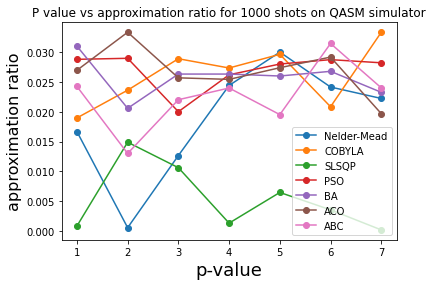

gradient_values_nm=[0.02946666666666668, 0.008133333333333336, 0.011300000000000004, 0.0454, 0.022100000000000012, 0.047833333333333346, 0.04153333333333334]
gradient_values_cobyla=[0.03280000000000002, 0.0417, 0.04850000000000001, 0.036933333333333346, 0.04066666666666667, 0.04143333333333335, 0.05056666666666666]
gradient_values_slsqp=[0.0005000000000000002, 0.025566666666666682, 0.020233333333333343, 0.004333333333333336, 0.01646666666666667, 0.018700000000000005, 0.0026000000000000007]
swarm_values=[0.03436666666666668, 0.04400000000000001, 0.026800000000000008, 0.04603333333333335, 0.03646666666666668, 0.04706666666666669, 0.04396666666666667]
bats_values=[0.03253333333333335, 0.036300000000000006, 0.028633333333333347, 0.03880000000000001, 0.049900000000000014, 0.048666666666666664, 0.03290000000000002]
ants_values=[0.032966666666666686, 0.04640000000000001, 0.046666666666666676, 0.049966666666666666, 0.04433333333333335, 0.0444, 0.043300000000000005]
bees_values=[0.0330000000000

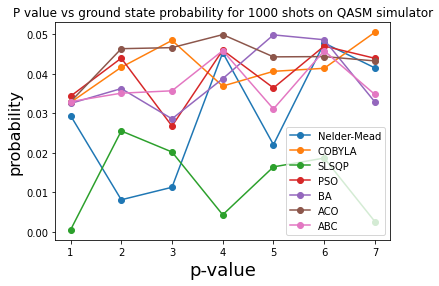

gradient_time_nm=[14.473073482513428, 38.866825580596924, 82.59033536911011, 128.22860074043274, 177.72081184387207, 249.85546469688416, 337.271781206131]
gradient_time_cobyla=[0.9851250648498535, 2.391822099685669, 5.42863655090332, 5.7031285762786865, 9.29817819595337, 13.016186475753784, 18.093990087509155]
gradient_time_slsqp=[4.120060205459595, 14.651715993881226, 31.712034940719604, 57.895790100097656, 71.12090158462524, 163.82520198822021, 244.4157121181488]
swarm_time=[35.58557367324829, 49.48150587081909, 70.30939936637878, 77.16244339942932, 101.0408947467804, 112.50514554977417, 118.52637910842896]
bats_time=[102.20213484764099, 140.45914125442505, 198.31027960777283, 219.5235960483551, 286.30943989753723, 299.899130821228, 335.07570362091064]
ants_time=[46.814300775527954, 64.31138229370117, 91.54293012619019, 100.80025863647461, 133.04089164733887, 137.56571006774902, 155.9234058856964]
bees_time=[82.5186550617218, 123.12177848815918, 162.0545778274536, 178.9509494304657, 

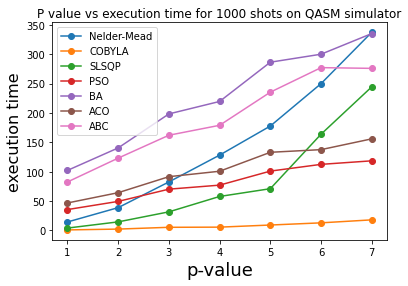

In [15]:
test_n_nodes(6,'000111', G, solutions)

# 7 nodes graph

0000111 12


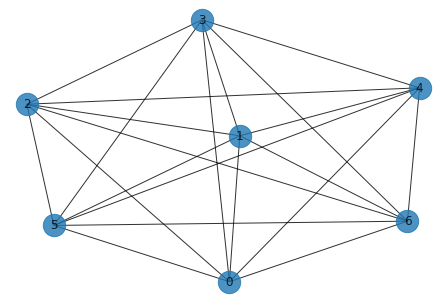

In [5]:
G, solutions = get_objective(7, 12)



gradient_sum_nm=[0.959, 0.4479999999999976, 0.055999999999999266, 0.844666666666687, 0.41066666666666046, 1.0336666666666627, 0.9333333333333349]
gradient_sum_cobyla=[0.9543333333333343, 0.9659999999999849, 1.0686666666666376, 0.9543333333333466, 0.7816666666666543, 0.9146666666666718, 0.9986666666666477]
gradient_sum_slsqp=[0.5366666666666677, 0.12599999999999584, 0.06066666666666464, 0.023333333333333352, 0.1563333333333303, 0.07933333333333104, 0.1353333333333282]
swarm_sum[0.8819999999999951, 0.9146666666666463, 0.8540000000000048, 0.7933333333333271, 0.8563333333333393, 0.9146666666666591, 0.8563333333333495]
bats_sum=[0.9636666666666684, 0.9216666666666561, 0.9286666666666625, 0.9333333333333247, 0.7280000000000015, 0.8353333333333383, 0.9473333333333375]
ants_sum=[0.9379999999999917, 0.9263333333333363, 1.0359999999999978, 0.8820000000000093, 0.9659999999999989, 0.6509999999999965, 0.7979999999999989]
bees_sum=[1.0523333333333373, 0.9939999999999932, 0.9146666666666793, 0.8423

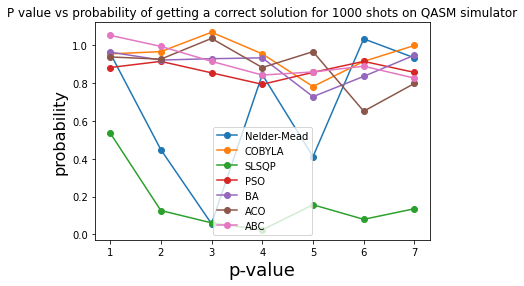

gradient_values_nm_p=[0.025333333333333333, 0.006382978723404255, 0.0016666666666666668, 0.01851851851851852, 0.00808080808080808, 0.023611111111111114, 0.016666666666666666]
gradient_values_cobyla_p=[0.016666666666666666, 0.011538461538461537, 0.025757575757575757, 0.03181818181818182, 0.01746031746031746, 0.022727272727272724, 0.0196969696969697]
gradient_values_slsqp_p=[0.01764705882352941, 0.0006060606060606061, 0.000529100529100529, 0.0008849557522123894, 0.0022222222222222222, 0.00013717421124828533, 0.0005698005698005699]
swarm_values_p[0.016666666666666666, 0.02638888888888889, 0.016666666666666666, 0.03333333333333333, 0.02807017543859649, 0.018666666666666668, 0.015789473684210527]
bats_values_p=[0.009333333333333334, 0.017391304347826087, 0.017333333333333333, 0.008974358974358974, 0.02380952380952381, 0.01388888888888889, 0.025396825396825397]
ants_values_p=[0.017391304347826087, 0.024637681159420288, 0.01111111111111111, 0.025, 0.027272727272727275, 0.01746031746031746, 0.

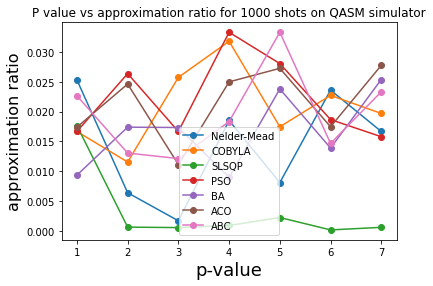

gradient_values_nm=[0.013700000000000007, 0.006400000000000002, 0.0008000000000000003, 0.012066666666666672, 0.005866666666666669, 0.014766666666666674, 0.013333333333333338]
gradient_values_cobyla=[0.013633333333333338, 0.013800000000000007, 0.015266666666666673, 0.013633333333333341, 0.011166666666666674, 0.013066666666666673, 0.014266666666666674]
gradient_values_slsqp=[0.00766666666666667, 0.0018000000000000008, 0.000866666666666667, 0.0003333333333333333, 0.002233333333333334, 0.0011333333333333338, 0.0019333333333333336]
swarm_values=[0.012600000000000005, 0.013066666666666673, 0.012200000000000006, 0.011333333333333338, 0.012233333333333339, 0.013066666666666673, 0.012233333333333339]
bats_values=[0.013766666666666674, 0.013166666666666672, 0.013266666666666675, 0.01333333333333334, 0.010400000000000005, 0.01193333333333334, 0.013533333333333342]
ants_values=[0.013400000000000006, 0.013233333333333338, 0.014800000000000008, 0.012600000000000007, 0.013800000000000007, 0.009300000

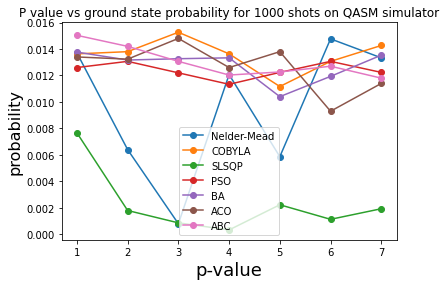

gradient_time_nm=[20.978727102279663, 50.798240423202515, 86.97160744667053, 141.46375179290771, 207.62609887123108, 292.04143500328064, 388.7491579055786]
gradient_time_cobyla=[1.8504021167755127, 3.0759522914886475, 5.3090760707855225, 7.250723600387573, 10.888532638549805, 14.494930982589722, 20.647801399230957]
gradient_time_slsqp=[7.952304840087891, 13.421935081481934, 2.511164665222168, 50.55979776382446, 111.7034285068512, 184.72224235534668, 249.5491487979889]
swarm_time=[46.328545808792114, 64.99914622306824, 73.90805721282959, 89.88861680030823, 105.93098783493042, 124.25872468948364, 146.6041955947876]
bats_time=[138.31909942626953, 184.21957564353943, 210.01922154426575, 258.342955827713, 299.66742396354675, 353.060781955719, 398.2746613025665]
ants_time=[61.60412359237671, 84.18439364433289, 96.94685435295105, 117.67474174499512, 139.41027665138245, 161.93400359153748, 188.03974413871765]
bees_time=[108.46208763122559, 150.3115861415863, 171.1264100074768, 208.300251483917

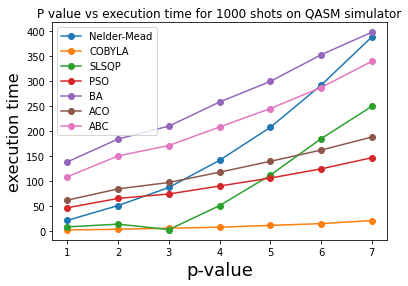

In [6]:
test_n_nodes(7,'0000111', G, solutions)

# 8 nodes graph

00001111 16


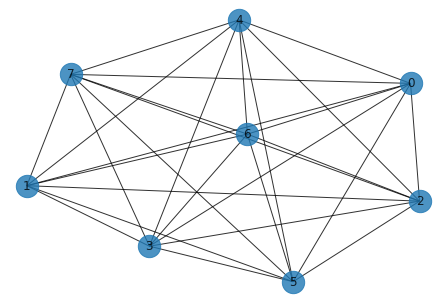

In [7]:
G, solutions = get_objective(8, 16)



gradient_sum_nm=[0.6066666666666698, 0.16799999999999787, 0.13066666666666196, 0.5833333333333213, 0.7816666666666671, 0.15399999999999728, 0.39899999999999436]
gradient_sum_cobyla=[0.6230000000000097, 0.597333333333341, 0.7256666666666747, 0.8680000000000151, 0.8610000000000025, 0.926333333333327, 0.9543333333333346]
gradient_sum_slsqp=[0.17966666666666645, 0.3079999999999889, 0.11666666666666388, 0.08166666666666371, 0.10499999999999605, 0.13533333333333059, 0.11666666666666328]
swarm_sum[0.5763333333333394, 1.0406666666666824, 0.5739999999999976, 0.5786666666666723, 0.7629999999999978, 0.8540000000000023, 0.5483333333333263]
bats_sum=[0.7163333333333398, 0.947333333333345, 0.6113333333333356, 0.128333333333331, 0.8376666666666773, 0.9169999999999935, 0.45966666666666345]
ants_sum=[0.823666666666666, 0.8960000000000075, 0.4829999999999978, 0.5436666666666652, 0.5763333333333269, 0.7863333333333372, 0.3593333333333305]
bees_sum=[0.6043333333333256, 0.6626666666666652, 0.730333333333

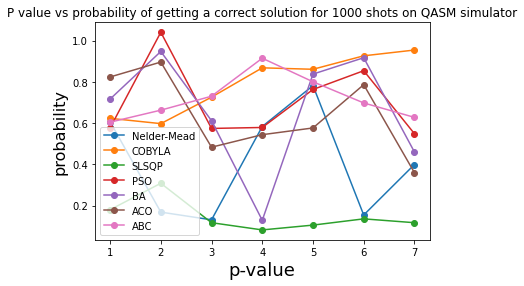

gradient_values_nm_p=[0.017777777777777778, 0.0010256410256410256, 0.0033333333333333335, 0.016666666666666666, 0.01111111111111111, 0.008333333333333333, 0.017777777777777778]
gradient_values_cobyla_p=[0.029411764705882353, 0.01568627450980392, 0.024074074074074074, 0.021666666666666667, 0.014492753623188406, 0.016666666666666666, 0.016666666666666666]
gradient_values_slsqp_p=[0.0022222222222222222, 0.02333333333333333, 0.0033333333333333335, 0.0007575757575757576, 0.0005649717514124294, 0.0, 0.0]
swarm_values_p[0.00625, 0.020833333333333332, 0.008771929824561403, 0.02888888888888889, 0.014035087719298244, 0.014492753623188406, 0.0044444444444444444]
bats_values_p=[0.011666666666666665, 0.025396825396825397, 0.0125, 0.0, 0.005333333333333333, 0.01111111111111111, 0.024444444444444442]
ants_values_p=[0.029411764705882353, 0.017333333333333333, 0.017948717948717947, 0.010256410256410256, 0.02142857142857143, 0.015000000000000001, 0.014285714285714285]
bees_values_p=[0.02888888888888889,

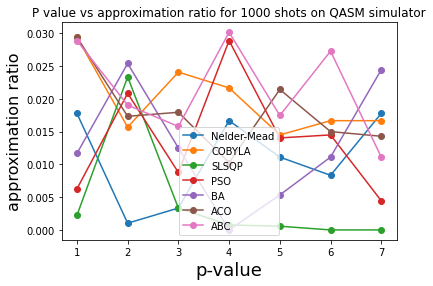

gradient_values_nm=[0.008666666666666671, 0.002400000000000001, 0.0018666666666666673, 0.008333333333333337, 0.011166666666666674, 0.0022000000000000006, 0.005700000000000003]
gradient_values_cobyla=[0.008900000000000003, 0.008533333333333337, 0.01036666666666667, 0.012400000000000007, 0.012300000000000004, 0.01323333333333334, 0.01363333333333334]
gradient_values_slsqp=[0.0025666666666666676, 0.004400000000000001, 0.0016666666666666674, 0.001166666666666667, 0.0015000000000000007, 0.0019333333333333342, 0.0016666666666666672]
swarm_values=[0.008233333333333337, 0.014866666666666674, 0.008200000000000004, 0.00826666666666667, 0.010900000000000003, 0.012200000000000006, 0.007833333333333336]
bats_values=[0.010233333333333337, 0.01353333333333334, 0.008733333333333338, 0.001833333333333334, 0.011966666666666672, 0.013100000000000004, 0.0065666666666666694]
ants_values=[0.011766666666666672, 0.012800000000000006, 0.0069000000000000025, 0.007766666666666669, 0.008233333333333337, 0.0112333

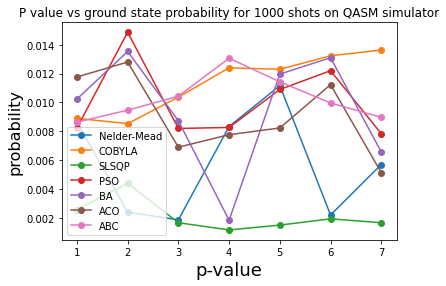

gradient_time_nm=[20.357147216796875, 55.359447956085205, 109.99561429023743, 181.83660221099854, 264.6224265098572, 343.8136467933655, 519.0738084316254]
gradient_time_cobyla=[1.4550063610076904, 3.2279603481292725, 5.80294942855835, 9.840205192565918, 16.339497566223145, 18.371793746948242, 23.476093769073486]
gradient_time_slsqp=[6.115060567855835, 23.22414541244507, 46.80518627166748, 82.00779104232788, 90.76107478141785, 236.87235856056213, 359.03959798812866]
swarm_time=[52.20150423049927, 70.74732303619385, 95.4510760307312, 117.03326630592346, 125.51576828956604, 171.29685997962952, 169.8986415863037]
bats_time=[146.16353225708008, 201.26780796051025, 252.15191102027893, 323.3020763397217, 391.24134516716003, 419.0728862285614, 518.3982145786285]
ants_time=[66.49352931976318, 93.58237075805664, 123.8217260837555, 153.0962631702423, 172.45865297317505, 198.67111563682556, 238.5685088634491]
bees_time=[117.53024077415466, 166.1586136817932, 223.91071724891663, 266.23389744758606,

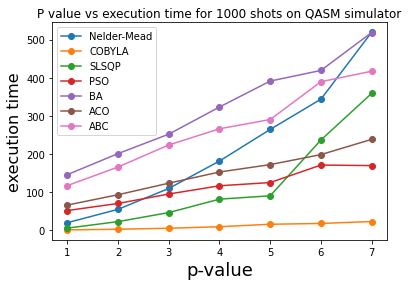

In [8]:
test_n_nodes(8,'00001111', G, solutions)

# 9 nodes graph

000001111 20


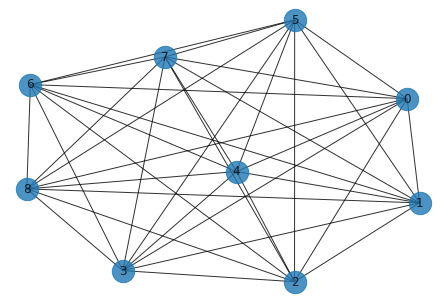

In [9]:
G, solutions = get_objective(9, 20)



gradient_sum_nm=[0.5964000000000025, 0.9491999999999775, 0.2688000000000097, 0.32759999999998646, 0.4031999999999867, 0.3864000000000022, 0.7812000000000229]
gradient_sum_cobyla=[1.0080000000000315, 0.7392000000000245, 0.9744000000000325, 0.6636000000000164, 0.6216000000000185, 1.075200000000038, 0.41159999999999214]
gradient_sum_slsqp=[0.06719999999999816, 0.17639999999999173, 0.03359999999999999, 0.008400000000000006, 0.3444000000000138, 0.041999999999999066, 0.32760000000000944]
swarm_sum[0.8316000000000173, 1.02479999999998, 0.8568000000000033, 0.7224000000000043, 0.7812000000000299, 0.8063999999999895, 0.6384000000000445]
bats_sum=[1.041600000000022, 1.0332000000000316, 0.7980000000000195, 0.77280000000002, 0.6300000000000285, 0.579599999999986, 0.6888000000000076]
ants_sum=[1.1171999999999989, 0.6720000000000178, 0.7643999999999888, 0.9240000000000623, 0.5544000000000042, 0.9996000000000463, 0.4451999999999945]
bees_sum=[0.8651999999999976, 0.8904000000000202, 0.688800000000014

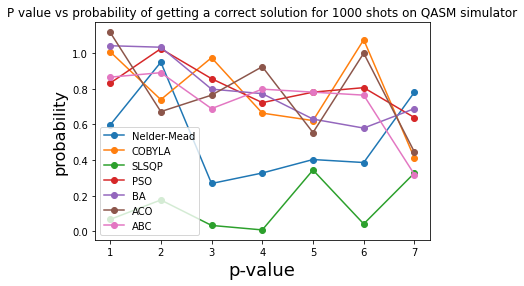

gradient_values_nm_p=[0.01, 0.016666666666666666, 0.002564102564102564, 0.0011111111111111111, 0.0017777777777777779, 0.0, 0.006666666666666667]
gradient_values_cobyla_p=[0.01515151515151515, 0.0037037037037037034, 0.014814814814814814, 0.006060606060606061, 0.013333333333333334, 0.02666666666666667, 0.007407407407407407]
gradient_values_slsqp_p=[0.0, 0.00046948356807511736, 0.0, 0.0, 0.00273224043715847, 0.0, 0.0023809523809523807]
swarm_values_p[0.01851851851851852, 0.024242424242424242, 0.006666666666666667, 0.0029629629629629632, 0.016666666666666666, 0.007407407407407407, 0.01111111111111111]
bats_values_p=[0.006666666666666667, 0.016666666666666666, 0.01, 0.010256410256410256, 0.008333333333333333, 0.0, 0.0034482758620689655]
ants_values_p=[0.01, 0.03333333333333333, 0.0030303030303030303, 0.005882352941176471, 0.01111111111111111, 0.0047619047619047615, 0.014814814814814814]
bees_values_p=[0.016666666666666666, 0.029166666666666667, 0.006666666666666667, 0.006060606060606061, 0.

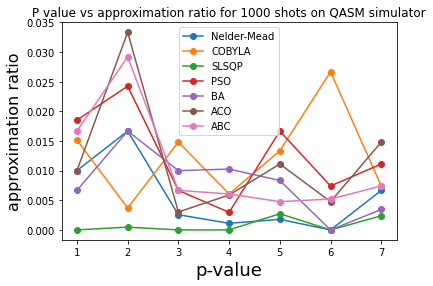

gradient_values_nm=[0.0023666666666666675, 0.003766666666666668, 0.001066666666666667, 0.0013000000000000004, 0.0016000000000000005, 0.0015333333333333338, 0.0031000000000000008]
gradient_values_cobyla=[0.004000000000000002, 0.002933333333333335, 0.003866666666666669, 0.0026333333333333347, 0.002466666666666668, 0.004266666666666669, 0.0016333333333333339]
gradient_values_slsqp=[0.0002666666666666667, 0.0007000000000000002, 0.00013333333333333334, 3.3333333333333335e-05, 0.0013666666666666669, 0.00016666666666666666, 0.0013000000000000002]
swarm_values=[0.0033000000000000013, 0.004066666666666668, 0.003400000000000001, 0.002866666666666668, 0.003100000000000001, 0.0032000000000000015, 0.002533333333333334]
bats_values=[0.004133333333333334, 0.004100000000000002, 0.0031666666666666675, 0.0030666666666666676, 0.002500000000000001, 0.002300000000000001, 0.0027333333333333346]
ants_values=[0.004433333333333335, 0.0026666666666666674, 0.0030333333333333345, 0.003666666666666668, 0.002200000

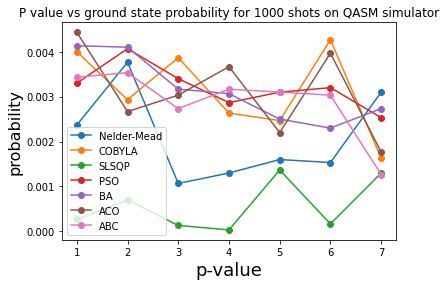

gradient_time_nm=[24.113948822021484, 66.81440591812134, 137.13501024246216, 223.520263671875, 327.43852162361145, 414.868376493454, 532.128035068512]
gradient_time_cobyla=[2.024503469467163, 4.111828327178955, 8.114865064620972, 12.843473196029663, 18.476301908493042, 21.475130319595337, 26.178544998168945]
gradient_time_slsqp=[9.623029708862305, 35.882296562194824, 74.29955315589905, 102.8648202419281, 151.46182227134705, 255.5509696006775, 77.07159090042114]
swarm_time=[59.72168946266174, 89.20330548286438, 113.9756236076355, 140.1363344192505, 166.8001606464386, 168.42781734466553, 197.56860089302063]
bats_time=[167.7831473350525, 243.47755551338196, 326.89050555229187, 383.012109041214, 475.30537247657776, 485.6463747024536, 551.535915851593]
ants_time=[78.91892957687378, 116.25654077529907, 149.86757016181946, 183.47431755065918, 217.70112013816833, 220.2269058227539, 257.72212076187134]
bees_time=[139.85904741287231, 205.84692001342773, 265.4658386707306, 325.5128765106201, 372.

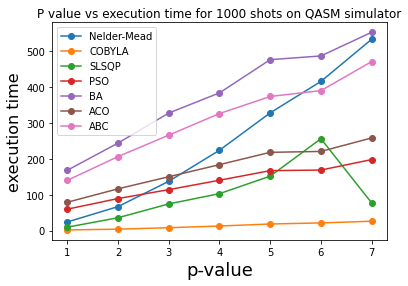

In [10]:
test_n_nodes(9,'000001111', G, solutions)